# Dask Array

Материалы:
* Макрушин С.В. Лекция 11: Dask
* https://docs.dask.org/en/latest/array.html
* JESSE C. DANIEL. Data Science with Python and Dask. 

## Задачи для совместного разбора

In [1]:
import dask
import dask.array as da
import numpy as np

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива.

In [2]:
%%time
arr_np = np.random.normal(0, 1, size=(1000,300_000))

CPU times: user 10.3 s, sys: 717 ms, total: 11 s
Wall time: 11.1 s


In [3]:
%%time
arr_da = da.random.normal(0, 1, size=(1000,300_000), chunks=(1000,30_000))
arr_da

CPU times: user 4.03 ms, sys: 5 µs, total: 4.04 ms
Wall time: 8.66 ms


dask.array<normal, shape=(1000, 300000), dtype=float64, chunksize=(1000, 30000), chunktype=numpy.ndarray>

2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

In [4]:
%%time
np.power(arr_np,2).sum()

CPU times: user 9.4 s, sys: 703 ms, total: 10.1 s
Wall time: 10.1 s


299984816.70788246

In [5]:
%%time
da.power(arr_da, 2).sum().compute()

CPU times: user 28.4 s, sys: 1.08 s, total: 29.5 s
Wall time: 18.8 s


300016151.70589715

3. Визуализируйте граф вычислений для задачи 2.

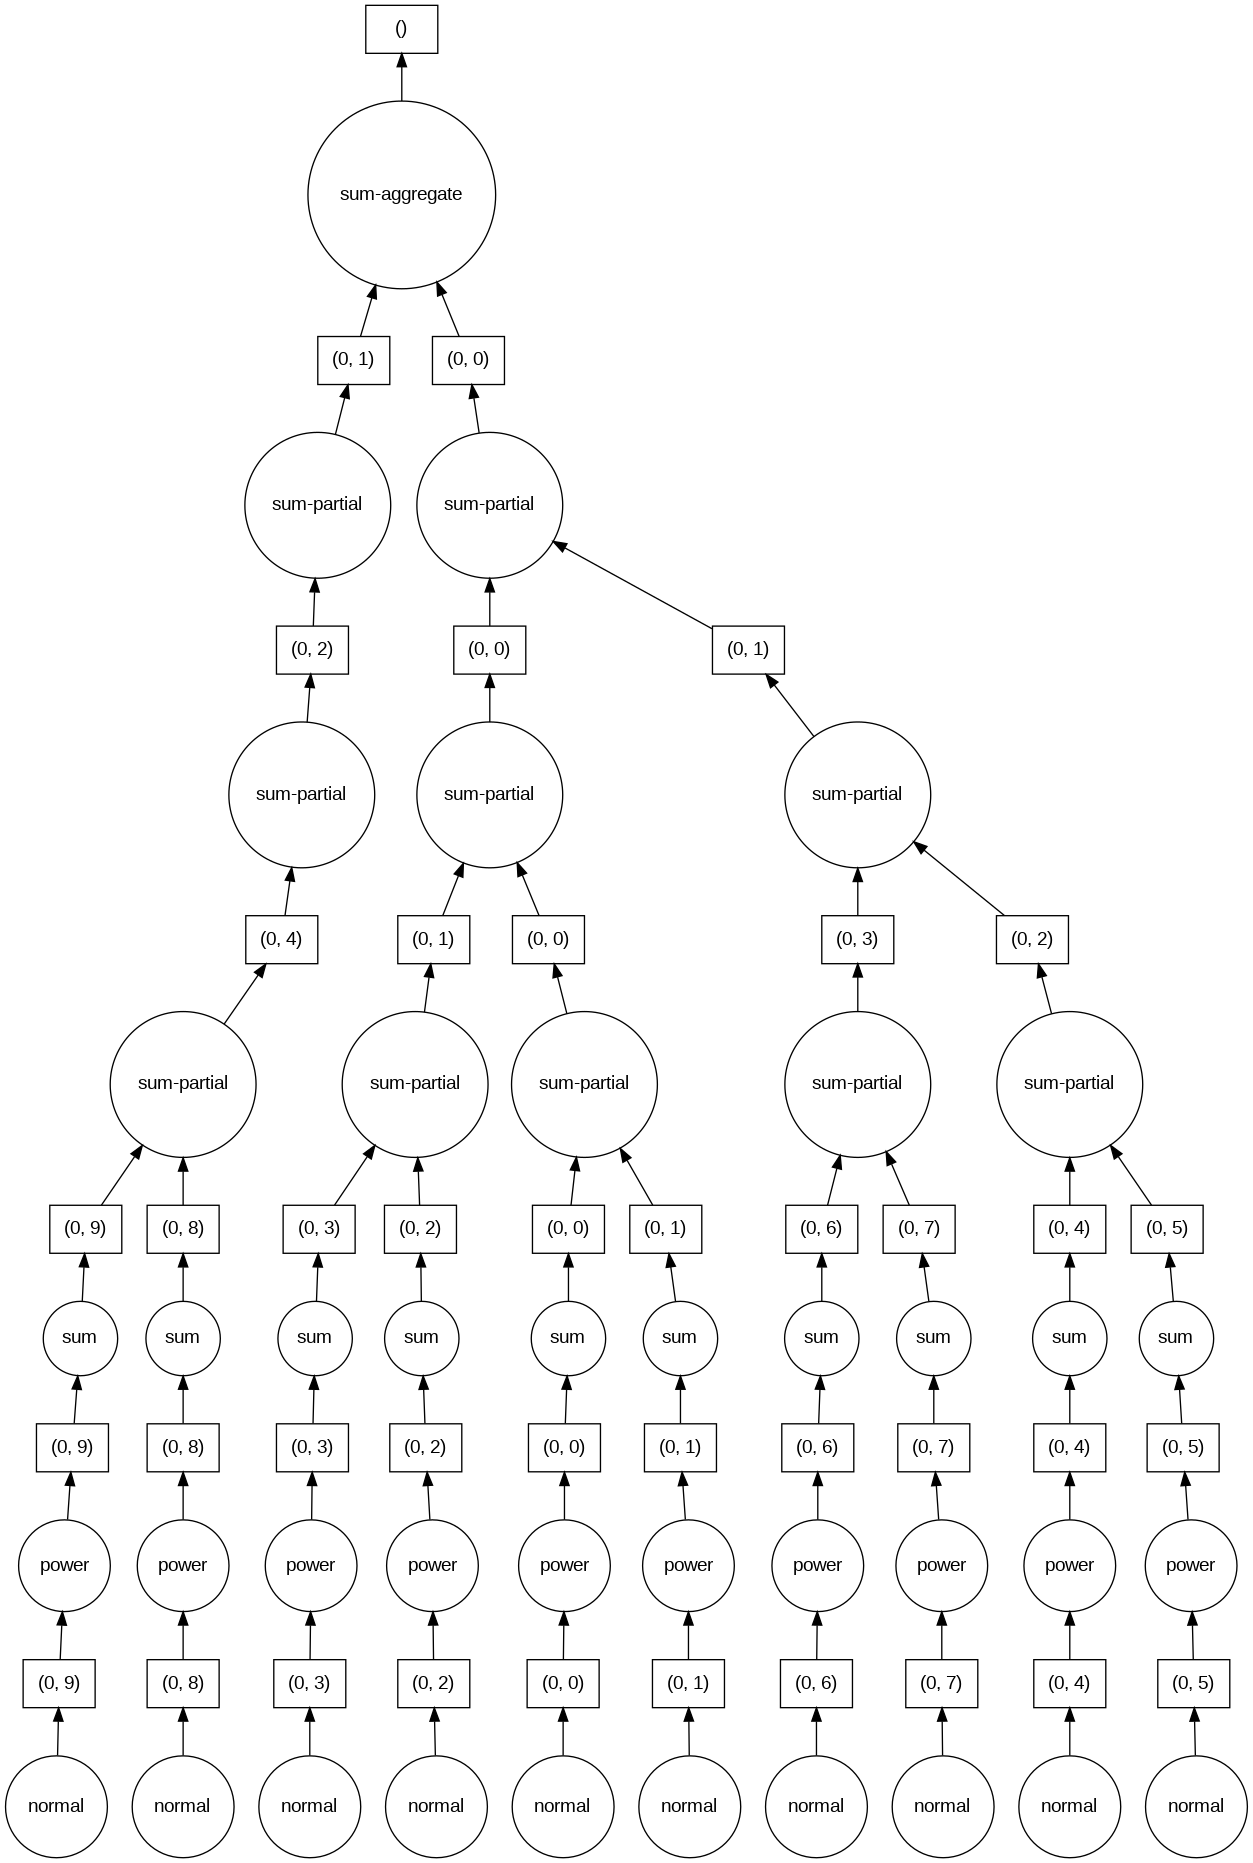

In [6]:
da.power(arr_da, 2).sum().visualize()

## Лабораторная работа 11

In [7]:
import dask.array as da
import h5py
import numpy as np

1. Считайте датасет `recipe` из файла `minutes_n_ingredients_full.hdf5` в виде `dask.array`. Укажите аргумент `chunks=(100_000, 3)` при создании массива. Выведите на экран основную информацию о массиве.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
ffile = h5py.File('/content/drive/MyDrive/minutes_n_ingredients_full.hdf5')
print(ffile['recipe'].attrs["description"])
recipes = da.from_array(ffile['recipe'], chunks=(100_000, 3))
print(recipes[1].compute())
recipes

Содержит столбцы id, minutes и n_ingredients из recipes_full.csv
[1089012      23       5]


dask.array<array, shape=(2231637, 3), dtype=int64, chunksize=(100000, 3), chunktype=numpy.ndarray>

2. Вычислите среднее значение по каждому столбцу, кроме первого. 

In [12]:
for i in range(1, recipes.shape[1]):
    print(i, recipes[:, i].mean().compute())

1 1004.2080517575215
2 5.419800800936711


3. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего. 

In [13]:
test_count = da.from_array(ffile['recipe'], chunks=(1_000_000, 3))

In [14]:
%%time
test_count.mean().compute()

CPU times: user 27.5 ms, sys: 41.7 ms, total: 69.3 ms
Wall time: 52.1 ms


375950.1723050538

In [15]:
test_count = da.from_array(ffile['recipe'], chunks=(100_000, 3))

In [16]:
%%time
test_count.mean().compute()

CPU times: user 47.5 ms, sys: 13.4 ms, total: 60.8 ms
Wall time: 54 ms


375950.1723050538

In [17]:
test_count = da.from_array(ffile['recipe'], chunks=(100, 3))

In [18]:
%%time
test_count.mean().compute()

CPU times: user 17.5 s, sys: 2.19 s, total: 19.6 s
Wall time: 18.2 s


375950.1723050538

Исходя из 3х операций выше где столбец разбивали на чанки можно увидеть разницу во времени вычисления. При первом выборе чанков мало, но они большие, тем самым скорость не самая высокая. В третьем примере наоборот чанков много, но они меньше, таким образом параллельно вычисляется много потоков.

4. Выберите рецепты, время выполнения которых меньше медианного значения

In [19]:
mediana = da.median(recipes[:, 1], axis=0).compute()
print(mediana)
recipes[recipes[:, 1] < mediana, :].compute()

32.0


array([[1089012,      23,       5],
       [1428572,       0,       5],
       [1400250,      24,       1],
       ...,
       [1029131,      19,       4],
       [1700703,       1,       1],
       [ 713836,       0,       9]])

5. Посчитайте количество каждого из возможных значений кол-ва ингредиентов

In [20]:
values, counts = da.unique(recipes[:, 2], return_counts=True)  #метод уникальных значений unique
for value, count in zip(values.compute(), counts.compute()):
    print(value, count)

1 222071
2 224158
3 229388
4 234948
5 240720
6 244360
7 247181
8 246747
9 246816
10 22430
11 19094
12 15165
13 11640
14 8284
15 6014
16 4145
17 2793
18 1913
19 1279
20 852
21 529
22 346
23 244
24 178
25 107
26 68
27 55
28 33
29 22
30 20
31 13
32 5
33 4
34 3
35 4
36 1
37 2
38 1
39 1
40 2
43 1


6. Найдите максимальную продолжительность рецепта. Ограничьте максимальную продолжительность рецептов сверху значением, равному 75% квантилю.

In [21]:
result = da.max(recipes[:, 1]).compute()
result

2147483647

In [22]:
quantile = 0.75
q_result = recipes.to_dask_dataframe()[1].quantile(quantile).compute()
q_result

49.0

In [23]:
recipes[recipes[:, 1] > q_result, 1] = q_result

In [25]:
result = da.max(recipes[:, 1]).compute()
result

49

7. Создайте массив `dask.array` из 2 чисел, содержащих ваши предпочтения относительно времени выполнения рецепта и кол-ва ингредиентов. Найдите наиболее похожий (в смысле $L_1$) рецепт из имеющихся в датасете.

In [27]:
TIME_MINUTES = 100
ITEMS_COUNT = 37
my_request = da.from_array([TIME_MINUTES, ITEMS_COUNT])

In [28]:
diff = my_request - recipes[:, 1:]
diff.compute()

array([[ 67,  28],
       [ 77,  32],
       [100,  32],
       ...,
       [ 51,  35],
       [100,  28],
       [ 51,  29]])

In [29]:
mask = da.fabs(diff).sum(axis=1).argmin()
mask.compute()

537986

In [30]:
result = recipes[mask].compute()
result

array([502219,     49,     37])

In [31]:
print(f"Рецепт {result[0]} наиболее похож по заданным критериям (minutes={TIME_MINUTES}, n_ingredients={ITEMS_COUNT})")

Рецепт 502219 наиболее похож по заданным критериям (minutes=100, n_ingredients=37)


8. Работая с исходным файлом в формате `hdf5`, реализуйте алгоритм подсчета среднего значения в блочной форме и вычислите с его помощью среднее значение второго столбца в массиве.

Блочный алгоритм вычислений состоит из двух частей:
1. Загрузка фрагмента за фрагментом данных по `blocksize` элементов и проведение вычислений на этим фрагментом
2. Агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных

Важно: при работе с `h5py` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент

In [32]:
import time

In [ ]:
ffile = h5py.File('/content/drive/MyDrive/minutes_n_ingredients_full.hdf5')

In [33]:
class BlocksCounter:
    """Счет по блокам"""
    def __init__(self, dataset : h5py._hl.dataset.Dataset, blocksize : int, column : int) -> None:
        self.dataset = dataset
        self.blocksize = blocksize
        self.column = column
        self.blocks_list = []
        
        self._result = None
        
        self.processing()
    
    def processing(self) -> None:
        """
        Управляющий метод для вычисления
        """
        self.first_step()
        self.second_step()
    
    def first_step(self) -> None:
        """
        Загрузка фрагмента за фрагментом данных по blocksize элементов и
        проведение вычислений на этим фрагментом;
        """
        dataset_len = self.dataset.shape[0]

        #Итерируемся с шагом по блоку
        for i in range(0, dataset_len + 1, self.blocksize):

            if (i + self.blocksize <= dataset_len + 1):
                stop = i + self.blocksize
            else:
                stop = dataset_len + 1

            #Добавление фрагментов по blocksize в список
            block_result = (self.dataset[i:stop, self.column].sum(), stop - i)
            self.blocks_list.append(block_result)
    
    def second_step(self) -> None:
        """
        Агрегация результатов вычислений на различных
        фрагментах для получения результата на уровне всего набора данных.
        """
        dataset_len = self.dataset.shape[0]
        items_list = []
        
        for block in self.blocks_list:
            items_list.append(block[0])

        self._result = sum(items_list) / dataset_len
    
    @property
    def result(self) -> float:
        if self._result is None:
            raise ValueError("Результат еще не был вычислен!")
        return self._result

In [34]:
start_time = time.time()
counter = BlocksCounter(dataset=ffile['recipe'], blocksize=100_000, column=1)
print(f"--- {time.time() - start_time} сек ---")
counter.result

--- 0.049162864685058594 сек ---


1004.2080517575215

In [35]:
#Еще раз обновляем recipes т.к. до этого его изменяли
recipes = da.from_array(ffile['recipe'], chunks=(100_000, 3))

In [36]:
start_time = time.time()
result = recipes[:, 1].mean().compute()
print(f"--- {time.time() - start_time} сек ---")
result

--- 0.06529593467712402 сек ---


1004.2080517575215